# Zombies Spread Dynamics
Simulation of the spread of a zombie epidemic in Europe, based on the modeling of the territory with graph theory, in order to take control measures with military troops and nuclear bombs to save the largest possible population. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import os, tqdm
import numpy as np
import datetime as dt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
plt.style.use('default')

from libraries.dynamics import spread_zombie_dynamics as szd
from libraries.dynamics import graph_by_default

## Network reading
After executing the notebook [graph construction](https://github.com/TEAM-IMT/zombies-spread-dynamics/blob/main/Codes/Challenge_2_graphconstruction.ipynb), the file **All_nodes_graph.gexf** will be generated. For convenience, we provide this file in zip format. The file is then unzipped.

In [2]:
graph_zip = './graph/without_see_nodes_graph_ini_2.zip'
graph_path = graph_zip.replace('.zip','.gexf')
if not os.path.isfile(graph_path):
    if not os.path.isdir('graph'): os.mkdir('graph')
    !unzip $graph_zip -d "./graph"
print('[INFO] File unzip successfully.')

[INFO] File unzip successfully.


## Epidemic spread
As a first view, let's load the network and see the initial state of the two populations

In [3]:
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [5]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
graph_pos = {G.nodes[n]['node_id']:(eval(n)[1],-eval(n)[0]) for n in G.nodes()}

[INFO] Graph was modified ...


In [6]:
dynamic.reset()
dynamic.graph_pos = graph_pos # Use variable to set an unique perspective

<IPython.core.display.Javascript object>


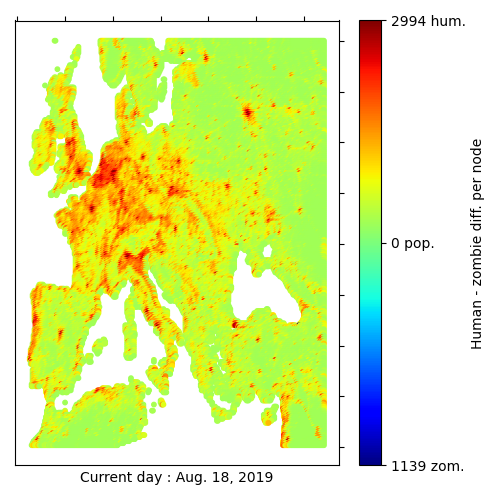

------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		18-08-2019
Total human population: 	29424646 (100.00\% of all population)
Total zombie population: 	1139 (0.00\% of all population)
Total human killed: 		0 (0.00\% of all population)
------------------------------


In [9]:
fig, ax = plt.subplots(figsize = (5,5))
dynamic.plot_graph(ax = ax)
print(dynamic)
# Cell aux
# for neig in dynamic.graph.neighbors('U45375'):
#     print("[INFO] humanpop in",neig,":",dynamic.graph.nodes[neig]['human_pop'],
#           "\tzombiepop :",dynamic.graph.nodes[neig]['zombie_pop'],
#          "\twith elev {}".format(('U45375',neig)),":",dynamic.graph.edges[('U45375',neig)]['elev_factor'])

In [10]:
print('[INFO] First zombie population in Rize', dynamic.graph.nodes['U45375']['zombie_pop'])
print('[INFO] First human population in Brest', dynamic.graph.nodes['U28058']['human_pop'])

[INFO] First zombie population in Rize 1139
[INFO] First human population in Brest 1532


Now, let's see how it evolves over time, over the course of two months.

  0%|          | 0/367 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


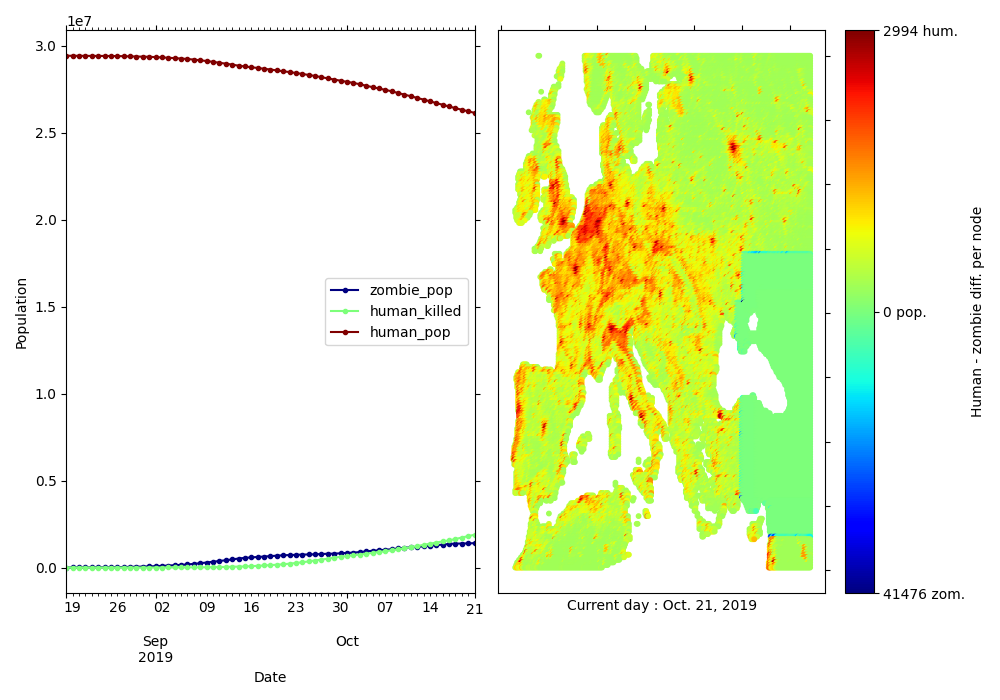

 17%|█▋        | 64/367 [43:59<3:28:16, 41.24s/it]


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3000x2100', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Dynamic spread zombie without action', '-metadata', 'artist=TEAM-IMT', '-metadata', 'comment=Dynamic evolution without any action', '-y', 'demo/anima_zombie_wa.mp4']' returned non-zero exit status 255.

In [11]:
# User values
DATE_END = dt.datetime.strptime('18-08-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ = '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_wa.mp4"
metadata = dict(title = 'Dynamic spread zombie without action', artist = 'TEAM-IMT', comment = 'Dynamic evolution without any action')

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        if dynamic.current_date < DATE_END: dynamic.step()
        elif dynamic.current_date == DATE_END: endtrigger = False

After two months, approximately one fifth of the land was conquered by the two zombies, turning 4.67% of the population into zombies, and eradicating 5.57% of the people on the European continent.

In [12]:
print(dynamic)

------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		21-10-2019
Total human population: 	26139751 (88.83\% of all population)
Total zombie population: 	1402724 (4.77\% of all population)
Total human killed: 		1883310 (6.40\% of all population)
------------------------------


## After 2 months
Bla bla

In [14]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [15]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.load_checkpoint('checkpoints/szd_17-10-2019.dyn')

[INFO] Graph was modified ...


<IPython.core.display.Javascript object>


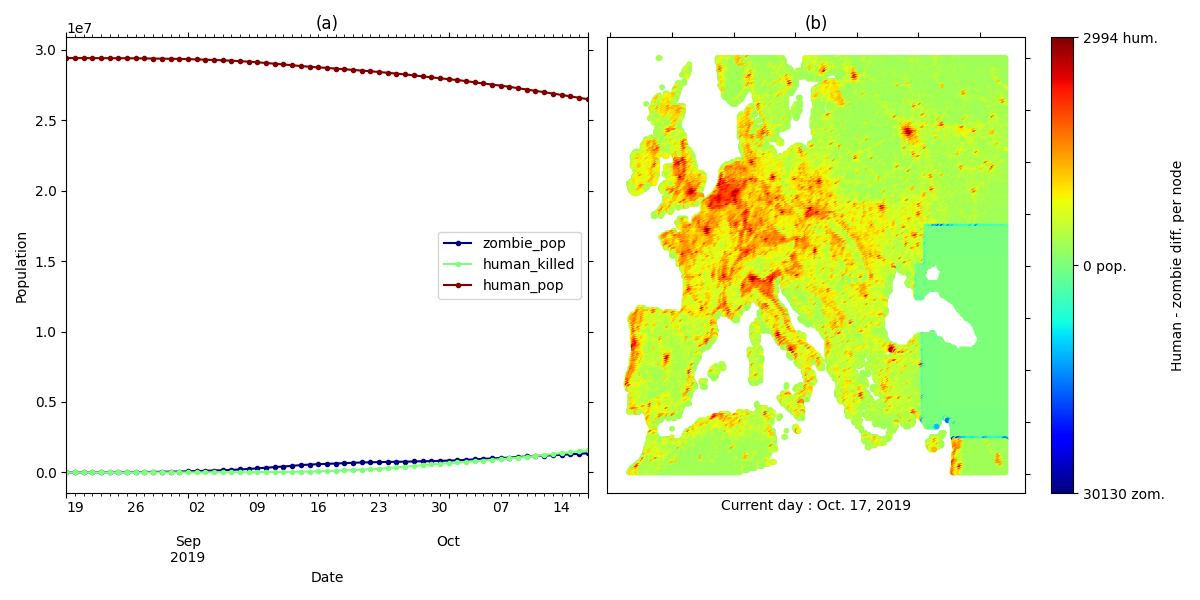

In [16]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
dynamic.plot_all(axs = axs)
axs[0].set_title('(a)'); axs[1].set_title('(b)')
fig.tight_layout()
fig.savefig('images/result_2months.png', dpi = 300,)

In [17]:
# Definition of military trops position
dynamic.MILITARY_TROPS = {dt.datetime.strptime('18-10-2019', '%d-%m-%Y'): # Start day with military trops
                  ['U59527','U59531','U59532','U26026','U55959','U26030','U47909','U26058',
                   'U26057','U26029','U59569','U59553','U26053','U26035','U32133','U56302',
                   'U59533','U26059','U26027','U59554']} # Cells with military deployment 

  0%|          | 0/367 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


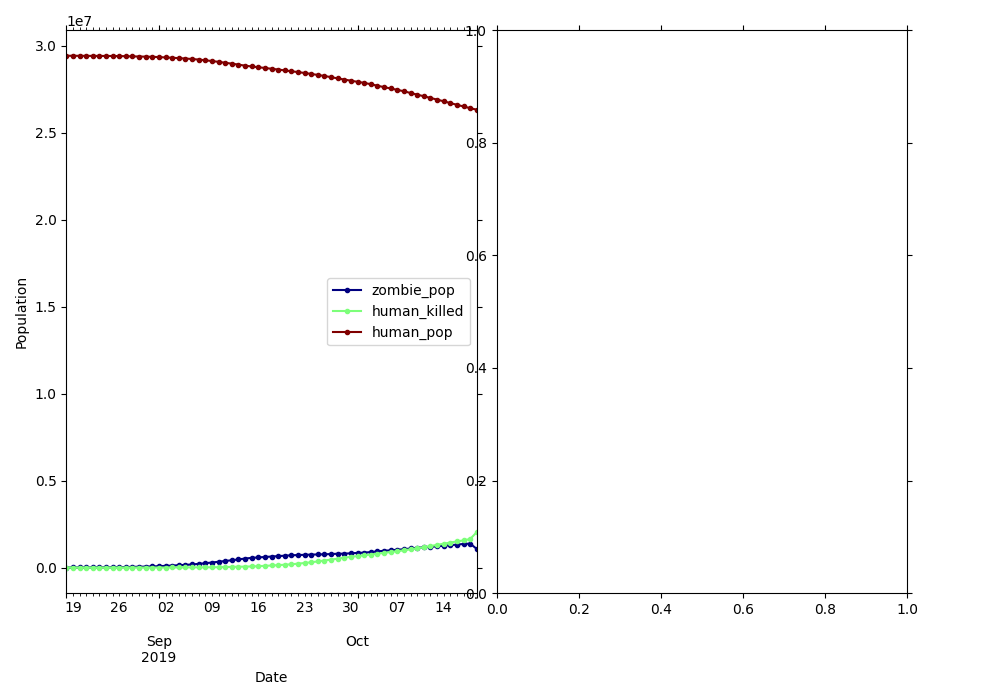

  0%|          | 1/367 [00:59<6:02:31, 59.43s/it]

[INFO] Military trops in 2019-10-18 00:00:00
[INFO] Nuclear bombs in 2019-10-18 00:00:00


  1%|          | 2/367 [01:49<5:32:45, 54.70s/it]


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3000x2100', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Dynamic with military action', '-metadata', 'artist=TEAM-IMT', '-metadata', 'comment=Dynamic evolution with military action', '-y', 'demo/anima_zombie_military.mp4']' returned non-zero exit status 255.

In [18]:
# User values
DATE_END = dt.datetime.strptime('18-08-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ = '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_military.mp4"
metadata = dict(title = 'Dynamic with military action', artist = 'TEAM-IMT', comment = 'Dynamic evolution with military action')

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        if dynamic.current_date < DATE_END: dynamic.step()
        elif dynamic.current_date == DATE_END: endtrigger = False

In [ ]:
print(dynamic)

## After 4 months
Bla bla

In [ ]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [ ]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.load_checkpoint('checkpoints/szd_17-12-2019.dyn')

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
dynamic.plot_all(axs = axs)
axs[0].set_title('(a)'); axs[1].set_title('(b)')
fig.tight_layout()
fig.savefig('images/result_bombs.png', dpi = 300,)

In [ ]:
# Definition of function to caculate bombs
def cells_bombs(G, date, beta = 0.9):
    zombiesquantity = nx.classes.function.get_node_attributes(G, 'zombie_pop')
    numberzombies = {i:v for i,v in zombiesquantity.items() if v > 0}
    hist, bins = np.histogram(list(numberzombies.values()), bins =100)
    hist = np.cumsum(hist)
    zombies = np.argmin(np.abs(hist - ((hist[-1] - hist[0]) * beta+ hist[0])))
    cells = {date: [i for i,v in numberzombies.items() if v >= bins[zombies]]}
    return cells

In [ ]:
# User values
DATE_END = dt.datetime.strptime('18-08-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ, BOMBS_FREQ = '15D', '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_bombs.mp4"
metadata = dict(title = 'Dynamic with nuclear bombs', artist = 'TEAM-IMT', comment = 'Dynamic evolution with nuclear bombs action')
bombs_dates = pd.date_range(start = '18-12-2019', end = DATE_END, freq = BOMBS_FREQ) # List of bombs days
beta = 0.9

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        bomb_date = dynamic.current_date + dt.timedelta(days = 1)
        if bomb_date in bombs_dates:
            if dynamic.NUCLEAR_BOMBS is None: dynamic.NUCLEAR_BOMBS = cells_bombs(dynamic.graph, bomb_date, beta)
            else: dynamic.NUCLEAR_BOMBS.update(cells_bombs(dynamic.graph, bomb_date, beta))
        if dynamic.current_date < DATE_END: dynamic.step()
        elif dynamic.current_date == DATE_END: endtrigger = False

In [ ]:
print(dynamic)